In [27]:
import numpy as np
from numpy.linalg import norm
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

class LsaHelper:
    def __init__(self,doc):        
        self.words_count_dict={}#紀錄 <字,字數>的字典
        self.sentCount=0
        
        for sent in doc.sents:
            for word in sent:
                #不考慮stop word跟標點符號
                if word.is_stop or word.is_punct:
                    continue
                #剩下的加入字典                
                self.words_count_dict[word.lemma_.lower()]=0
                
                    
        #print(self.words_count_dict)
    
    def getSentencesImportence(self , sents):
        #Sentences embedding
        wcDicts=[]
        _sc=0
        #每個句子的word count dict
        for s in sents:
            _wcDict = self.getCooccDict(s.lemma_)
            wcDicts.append(_wcDict)
            _sc+=1
        #print("word count dict: ",wcDicts)
        #合併成一個matrix
        self.f , self.d = self.combineVecsToMatrix(wcDicts)
        #u,s,vh = self.featuresSVD(f)        
        
        #Sentences relativities matrix (填充句子關聯程度矩陣 )
        self.sents_cosSim = np.arange(_sc*_sc).reshape(_sc,_sc).astype(float)
        for i in range(0,_sc):
            for j in range(0,_sc):
                a= self.f[i]
                b=self.f[j]
                sim1_2 = a@b /(norm(a)*norm(b))
                self.sents_cosSim[i,j]=sim1_2
        # nan轉0
        self.sents_cosSim[np.isnan(self.sents_cosSim)]=0
        #avg
        self.sents_avgSim= (self.sents_cosSim.sum(axis=1)-1)/(_sc-1)
        return self.sents_avgSim
    def drawFeatureHeatMap(self):
        #熱圖
        fig, ax = plt.subplots()
        count=len(self.sents_avgSim)
        labels= ["S"+ str(i) for i in np.arange(count)]
        ax.set_xticks(np.arange(count), labels=labels)
        ax.set_yticks(np.arange(count), labels=labels)

        plt.imshow(self.sents_cosSim, cmap='cool', interpolation='nearest')
        plt.show()

    
    #取得該句子的共現向量
    def getCooccDict(self,sent):
        words= sent.lower().split()
        temp_dict = self.words_count_dict.copy()
        for word in words:
            if word in temp_dict:
                temp_dict[word]+=1
        return temp_dict
    
    def combineDictToMatrix(self,pairs):
        pair_coDicts =[]
        for pair in pairs:
            pair_coDicts.append(pair.coVector)
        dictvectorizer = DictVectorizer(sparse=False)
        features = dictvectorizer.fit_transform(pair_coDicts)
        #print(features)
        #print(dictvectorizer.get_feature_names())
        return features,dictvectorizer
    
    def combineVecsToMatrix(self,coVecs):
        pair_coDicts =[]       
        dictvectorizer = DictVectorizer(sparse=False)
        features = dictvectorizer.fit_transform(coVecs)
        #print(features)
        #print(dictvectorizer.get_feature_names())
        return features,dictvectorizer
    
    def featuresSVD(self, features):
        u,s,vh = np.linalg.svd(features)
        self.u=u
        self.s=s
        self.vh =vh
        return u,s,vh
    #給定通過率，取得相對應的閥值
    def getPassThreshold(self,targetRate):
        xlab = np.arange(0.01,0.99,step=0.01) 
        for x in xlab:            
            y= sum(self.sents_avgSim>=x)/len(self.sents_avgSim)
            if y<=targetRate:                
                return x
 

In [28]:
if __name__ =="__main__":
    import spacy
    nlp = spacy.load("en_core_web_sm")    
    #text='Python is often described as a "batteries included" language due to Python comprehensive standard library.Python supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming.'
    '''
    text = 'General elections were held in Lesotho on 24 May 1998, except in the Moyeni constituency, where voting was postponed until 1 August due to the death of one of the candidates.\
            The result was a comprehensive victory for the new Lesotho Congress for Democracy, which claimed 79 of the 80 seats.\
            The party was formed by a breakaway from the Basutoland Congress Party, which had won the 1993 elections Of the 1,017,753 registered voters, there were 593,955 valid votes.'
    '''
    


In [29]:
text="Python is a high-level, interpreted, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation. \
        Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured , object-oriented and functional programming. It is often described as a 'batteries included' language due to its comprehensive standard library.\
        Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python-0.9.0. Python-2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support. Python-3.0, released in 2008, was a major revision that is not completely backward-compatible with earlier versions. Python-2 was discontinued with version-2.7.18 in 2020.\
        Python consistently ranks as one of the most popular programming languages. Python was conceived in the late 1980s by Guido van Rossum at Centrum Wiskunde and Informatica in the Netherlands as a successor to the ABC programming language, which was inspired by SETL, capable of exception handling and interfacing with the Amoeba operating system. Its implementation began in December-1989. Van Rossum shouldered sole responsibility for the project, as the lead developer, until 12 July 2018, when he announced his 'permanent vacation' from his responsibilities as Python's 'benevolent dictator for life', a title the Python community bestowed \
        upon him to reflect his long-term commitment as the project's chief decision-maker. In January-2019, active Python core developers elected a five-member Steering Council to lead the project.\
        Python-2.0 was released on 16 October 2000, with many major new features. Python-3.0, released on 3 December 2008, with many of its major features backported to Python-2.6.x and 2.7.x. Releases of Python-3 include\
        the 2to3 utility, which automates the translation of Python-2 code to Python-3."

text="Python is a high-level, interpreted, general-purpose programming language. Python's design philosophy emphasizes code readability with the use of significant indentation. \
        Python is dynamically-typed and garbage-collected. Python supports multiple programming paradigms, including structured , object-oriented and functional programming. Python is often described as a 'batteries included' language due to Python's comprehensive standard library.\
        Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released Python in 1991 as Python-0.9.0. Python-2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support. Python-3.0, released in 2008, was a major revision that is not completely backward-compatible with earlier versions. Python-2 was discontinued with version-2.7.18 in 2020.\
        Python consistently ranks as one of the most popular programming languages. Python was conceived in the late 1980s by Guido van Rossum at Centrum Wiskunde and Informatica in the Netherlands as a successor to the ABC programming language, which was inspired by SETL, capable of exception handling and interfacing with the Amoeba operating system. Python's implementation began in December-1989. Van Rossum shouldered sole responsibility for the project, as the lead developer, until 12 July 2018, when he announced Van Rossum's 'permanent vacation' from Van Rossum's responsibilities as Python's 'benevolent dictator for life', a title the Python community bestowed \
        upon Van Rossum to reflect Van Rossum's long-term commitment as the project's chief decision-maker. In January-2019, active Python core developers elected a five-member Steering Council to lead the project.\
        Python-2.0 was released on 16 October 2000, with many major new features. Python-3.0, released on 3 December 2008, with many of Python's major features backported to Python-2.6.x and 2.7.x. Releases of Python-3 include\
        the 2to3 utility, which automates the translation of Python-2 code to Python-3."  
#text="Python consistently ranks as one of the most popular programming languages."
    
doc= nlp(text)
    

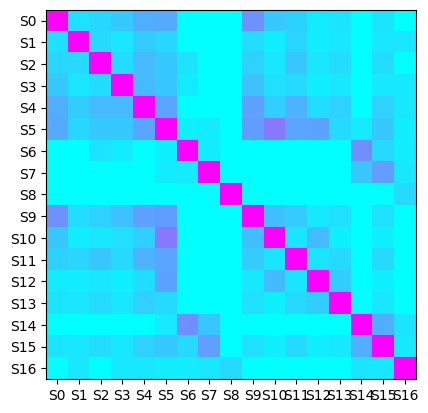

In [30]:


lsa = LsaHelper(doc)
sents = list(doc.sents)
lsa.getSentencesImportence(sents)
lsa.drawFeatureHeatMap()

c:\Users\User\anaconda3\envs\Spacy3_8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


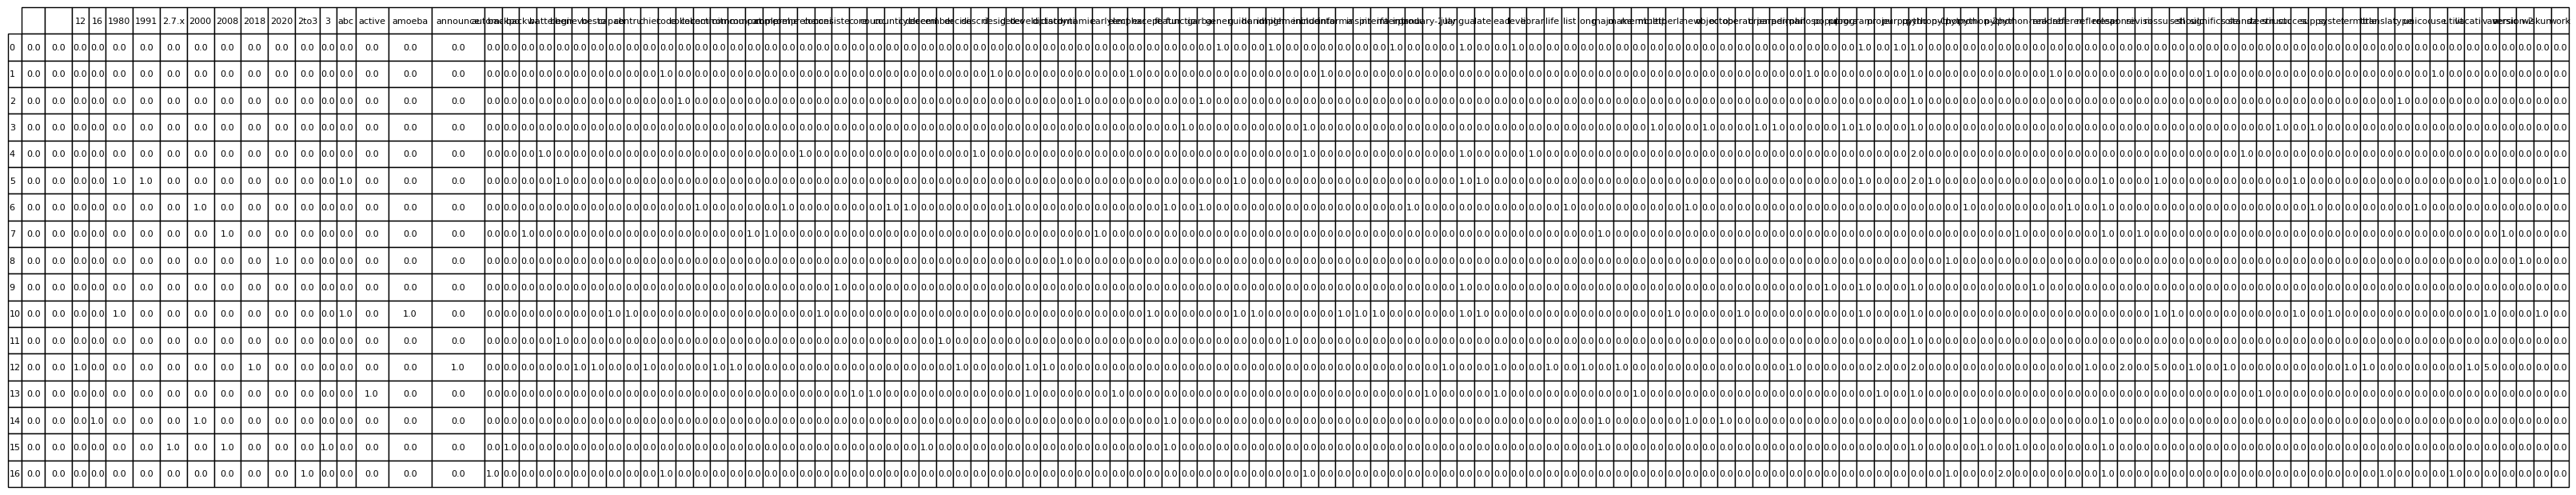

In [39]:
fig, ax = plt.subplots()
d = lsa.d
f = lsa.f
column_names = d.get_feature_names()
c=len(f[0])
#c=10
ax.axis("off")
table = plt.table(
        cellText=f[:,:c] ,
        colLabels= column_names[:c],
        rowLabels= np.arange(len(sents)),
        cellLoc='center',
        loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(sents)))) 

table.scale(6,2)

In [ ]:
# 轉向
fig, ax = plt.subplots()
column_names = d.get_feature_names()

#c=10
ax.axis("off")
table = plt.table(
        cellText=f.T ,
        rowLabels= column_names[:c],
        colLabels= np.arange(len(sents)),
        cellLoc='center',
        loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(sents)))) 

table.scale(6,2)

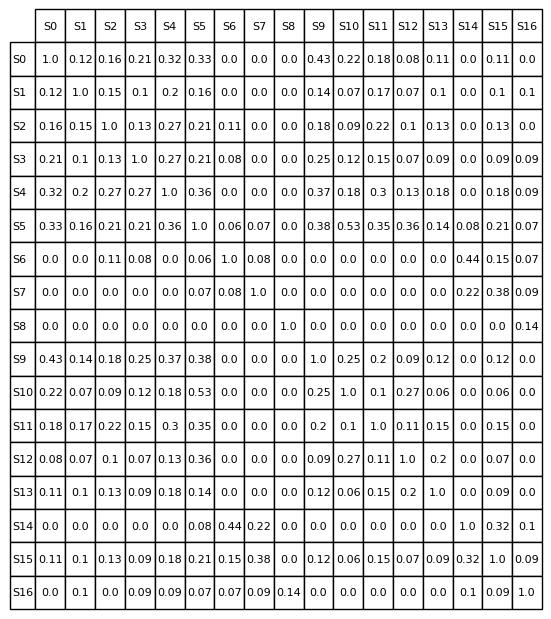

In [40]:

from numpy.linalg import norm
#填充句子關聯程度矩陣
count =len(sents)
sent_cosSim = np.arange(count*count).reshape(count,count).astype(float)
for i in range(0,len(sents)):
    for j in range(0,len(sents)):
        a= f[i]
        b=f[j]
        sim1_2 = a@b /(norm(a)*norm(b))
        sent_cosSim[i,j]=sim1_2

#做表格
with np.printoptions(precision=2, suppress=True):
    #print(sent_cosSim)
    fig, ax = plt.subplots()
    table = plt.table(
        cellText=np.round(sent_cosSim,2) ,
        rowLabels= ["S"+ str(i) for i in np.arange(count)],
        colLabels= ["S"+ str(i) for i in np.arange(count)],
        cellLoc='center',
        loc='center'
    )
    ax.axis("off")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.auto_set_column_width(col=list(range(len(sents)))) 

    table.scale(6,2)

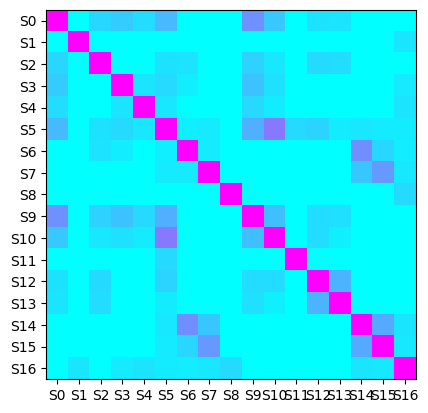

In [ ]:
#熱圖
fig, ax = plt.subplots()
labels= ["S"+ str(i) for i in np.arange(count)]
ax.set_xticks(np.arange(count), labels=labels)
ax.set_yticks(np.arange(count), labels=labels)

plt.imshow(sent_cosSim, cmap='cool', interpolation='nearest')
plt.show()

In [ ]:
'''
print(sents[16].text , sents[8].text)
print(sents[11].text)
print(sents[6].text)
print(sents[0].text)
'''
for t in sents:
    print(t.text)
    print()

Python is a high-level, interpreted, general-purpose programming language.
Its design philosophy emphasizes code readability with the use of significant indentation.         
Python is dynamically-typed and garbage-collected.
It supports multiple programming paradigms, including structured , object-oriented and functional programming.
It is often described as a 'batteries included' language due to its comprehensive standard library.        
Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python-0.9.0.
Python-2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support.
Python-3.0, released in 2008, was a major revision that is not completely backward-compatible with earlier versions.
Python-2 was discontinued with version-2.7.18 in 2020.        
Python consistently ranks as one of the most popular pro

17
[0.14115582 0.09161888 0.11865557 0.11650903 0.17846641 0.22097504
 0.06187687 0.05311697 0.0090211  0.15880599 0.12210246 0.13056458
 0.09528113 0.08620801 0.07317156 0.14116011 0.0522024 ]


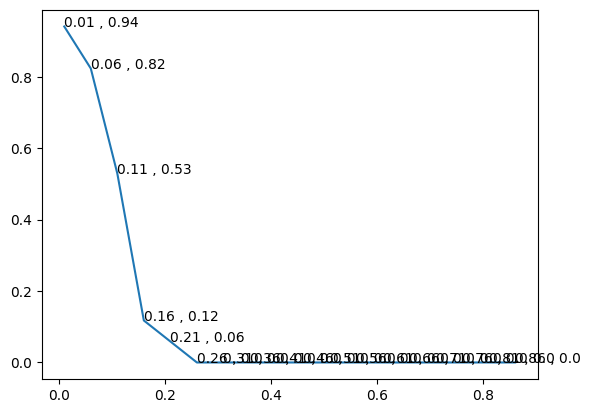

0.21000000000000002
0.26
0.31000000000000005
0.36000000000000004
0.41000000000000003
0.46
0.51
0.56
0.6100000000000001
0.66
0.7100000000000001
0.76
0.81
0.8600000000000001


In [42]:
#每一列累加後平均，便是重要度
print(count)
row_sum = (sent_cosSim.sum(axis=1)-1)/(count-1)
print(row_sum)

avg= row_sum

xlab = np.arange(0.01,0.9,step=0.05) #閥值
ylab=[]  #通過率
for x in xlab:
    ylab.append(sum(avg>=x)/len(avg))
    
plt.plot(xlab,ylab)
for a,b in zip(xlab, ylab): 
    plt.text(a, b, str(round(a,2))+" , "+str(round(b,2)))
plt.show()

target=0.1
for x in xlab:
    y= sum(avg>=x)/len(avg)
    if y<=target:
        print(x)

In [46]:
the= lsa.getPassThreshold(0.5)
i=0
for sim in lsa.sents_avgSim:
    if lsa.sents_avgSim[i] >=the:
        print('保留 ','S',i,sents[i])
    else :
        print('剔除 ','S',i,sents[i])
    i+=1

保留  S 0 Python is a high-level, interpreted, general-purpose programming language.
剔除  S 1 Python's design philosophy emphasizes code readability with the use of significant indentation.         
剔除  S 2 Python is dynamically-typed and garbage-collected.
剔除  S 3 Python supports multiple programming paradigms, including structured , object-oriented and functional programming.
保留  S 4 Python is often described as a 'batteries included' language due to Python's comprehensive standard library.        
保留  S 5 Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released Python in 1991 as Python-0.9.0.
剔除  S 6 Python-2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support.
剔除  S 7 Python-3.0, released in 2008, was a major revision that is not completely backward-compatible with earlier versions.
剔除  S 8 Python-2 was discontinued